In [2]:
import numpy as np
import pandas as pd

def benchmark(x1, x2):
    return (    (1.3356 * (1.5 * (1 - x1))) 
                + (np.exp((2 * x1) - 1) * np.sin((3 * np.pi) * ((x1 - 0.6) ** 2)))
                + (np.exp(3 * (x2 - 0.5)) * np.sin((4 * np.pi) * ((x2 - 0.9) ** 2)))
            )

def getData(grid):
    x1 = np.linspace(0, 1, grid)
    x2 = np.linspace(0, 1, grid)
    x1, x2 = np.meshgrid(x1, x2)
    f_x1_x2 = benchmark(x1, x2)
    data = {'x1': x1.flatten(), 'x2': x2.flatten(), 'f(x1,x2)': f_x1_x2.flatten()}
    df = pd.DataFrame(data)
    return df


df_1000 = getData(32)
df_test = pd.read_excel("../Kriging-data.xlsx", sheet_name="Test")
df_training = pd.read_excel("../Kriging-data.xlsx", sheet_name="Training")

exponential = pd.read_excel("../VirtualSamples.xlsx", sheet_name="Exponential")
spherical = pd.read_excel("../VirtualSamples.xlsx", sheet_name="Spherical")
gaussian = pd.read_excel("../VirtualSamples.xlsx", sheet_name="Gaussian")

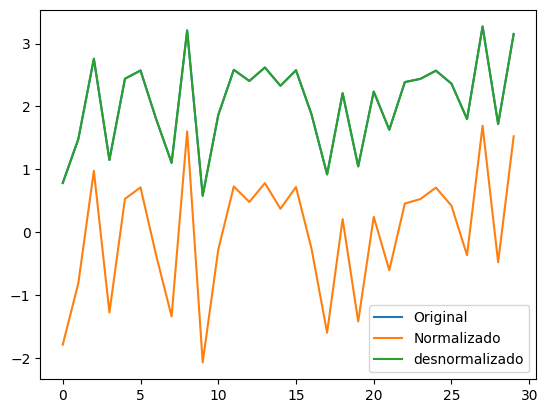

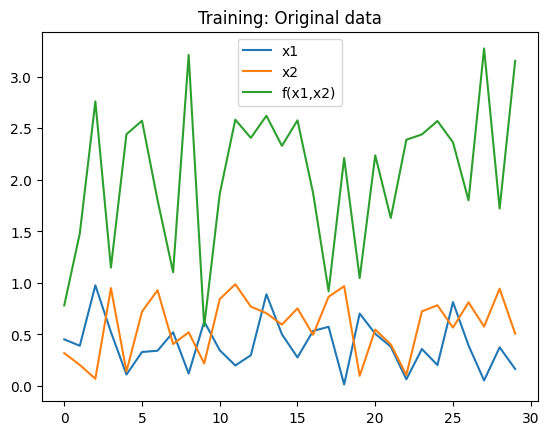

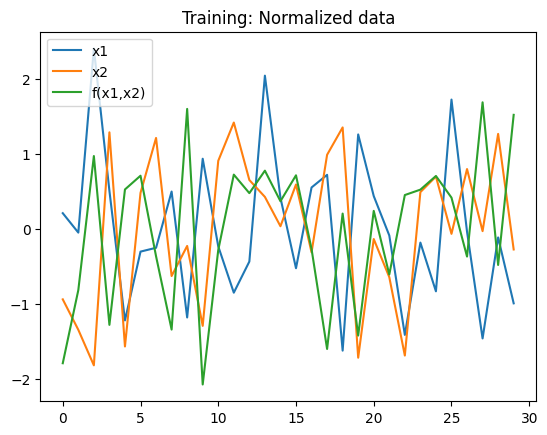

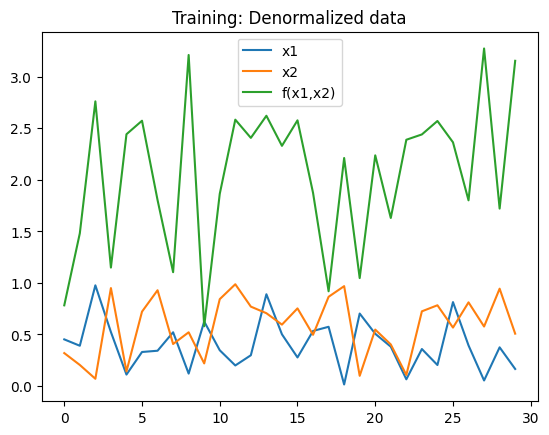

In [3]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
out_scaler = StandardScaler()

def show_norm(df, label="data", plot=False):
    df_norm = pd.DataFrame(scaler.transform(df), columns=df.columns)
    df_denorm = pd.DataFrame(scaler.inverse_transform(df_norm), columns=df_norm.columns)

    if (plot):
        df.plot(title=f"{label}: Original data")
        df_norm.plot(title=f"{label}: Normalized data")
        df_denorm.plot(title=f"{label}: Denormalized data")
    return (df_norm)


def test_out_scaler(df):
    out = df["f(x1,x2)"].values.reshape(-1, 1)  
    plt.plot(out, label='Original')
    out_scaler.fit(out)
    norm = out_scaler.transform(out)
    plt.plot(norm, label='Normalizado')
    plt.plot(out_scaler.inverse_transform(norm), label='desnormalizado')
    plt.legend()
    plt.show()

scaler.fit(df_training)
test_out_scaler(df_training)

df_training_norm = show_norm(df_training, "Training", True)
df_1000_norm = show_norm(df_1000)
df_exponential_norm = show_norm(pd.concat([df_training, exponential]))
df_spherical_norm = show_norm(pd.concat([df_training, spherical]))
df_gaussian_norm = show_norm(pd.concat([df_training, gaussian]))


In [5]:
import os

os.chdir("./content")

lm_dir = "tf-levenberg-marquardt"
if not os.path.exists(lm_dir):
  !git clone https://github.com/fabiodimarco/$lm_dir

os.chdir(lm_dir)

In [6]:
def split_df(df):
    _input = np.vstack([df['x1'], df['x2']]).T
    _output = np.array(df['f(x1,x2)'])
    return (_input, _output)

In [7]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def compute_k(self):
        total_parameters = 0
        for layer in self.model.layers:
            weights = layer.get_weights()
            if len(weights) > 0:  
                for w in weights:
                    total_parameters += np.prod(w.shape)
        return total_parameters
        
    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer

        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
            loss=tf.keras.losses.MeanSquaredError())

        self.lm_model = lm.ModelWrapper(
            tf.keras.models.clone_model(self.model))

        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.MeanSquaredError())
        return(self.lm_model)

2024-07-20 20:42:32.570883: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-20 20:42:32.602250: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-20 20:42:32.602279: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-20 20:42:32.603291: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-20 20:42:32.608764: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-20 20:42:32.609803: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [8]:
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error 

class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
        self.batch_size = batch_size
        self.betters = []
        self.k = 0

    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)
      dataset = tf.data.Dataset.from_tensor_slices((input, output))
      dataset = dataset.shuffle(len(input))
      dataset = dataset.batch(self.batch_size).cache()
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (dataset, input, output)

    def split_dataset(self, input, output, sup_input, sup_output):
      input_train, input_vt, output_train, output_vt = train_test_split(input, output, test_size=0.3, shuffle = True)
      input_val, input_test, output_val, output_test = train_test_split(input_vt, output_vt, test_size=0.5, shuffle = True)

      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(input_test, output_test)
      self.vt_dataset, self.vt_input, self.vt_output = self.create_dataset(input_vt, output_vt)
      self.sup_dataset, self.sup_input, self.sup_output = self.create_dataset(sup_input, sup_output)
      self.dataset, self.input, self.output = self.create_dataset(input, output)

      self._data = (input, output)
      self._train = (input_train, output_train)
      self._vt = (input_vt, output_vt)
      self._val = (input_val, output_val)
      self._test = (input_test, output_test)
      self._sup = (sup_input, sup_output)

    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)

      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)
    
    def get_new_metrics(self, orig, pred, r2, mse):
      n = len(orig) # N: quantidade de saidas
      k = self.k
      waste = (orig.flatten() - pred.flatten())

      mape = mean_absolute_percentage_error(orig, pred)  
      r2_adj = 1 - (((n - 1)/(n - k - 1)) * (1 - r2))
      rsd = np.sqrt(np.sum(waste ** 2) / (n - 2))
      rmse = root_mean_squared_error(orig, pred)          
      aic = (-2 * np.log(mse)) + (2 * k)
      bic = (-2 * np.log(mse)) + (k * np.log(n))
      return (mape, r2_adj, rsd, rmse, aic, bic)
      

    def get_metrics(self):
          # Calculando a saida com os dados normalizados
          pred = self.lm_model.predict(self.input).flatten()
          test_pred = self.lm_model.predict(self.test_input).flatten()
          val_pred = self.lm_model.predict(self.val_input).flatten()
          vt_pred = self.lm_model.predict(self.vt_input).flatten()
          sup_pred = self.lm_model.predict(self.sup_input).flatten()

          # Calculando as metricas com a saida desnormalizada
          pred_denorm = out_scaler.inverse_transform(pred.reshape(-1, 1))
          test_pred_denorm = out_scaler.inverse_transform(test_pred.reshape(-1, 1))
          val_pred_denorm = out_scaler.inverse_transform(val_pred.reshape(-1, 1))
          vt_pred_denorm = out_scaler.inverse_transform(vt_pred.reshape(-1, 1))
          sup_pred_denorm = out_scaler.inverse_transform(sup_pred.reshape(-1, 1))

          out_denorm = out_scaler.inverse_transform(self._data[1].reshape(-1, 1))
          test_denorm = out_scaler.inverse_transform(self._test[1].reshape(-1, 1))
          val_denorm = out_scaler.inverse_transform(self._val[1].reshape(-1, 1))
          vt_denorm = out_scaler.inverse_transform(self._vt[1].reshape(-1, 1))    
          sup_denorm = out_scaler.inverse_transform(self._sup[1].reshape(-1, 1))

          r2 = r2_score(out_denorm, pred_denorm)
          r2_test = r2_score(test_denorm, test_pred_denorm)
          r2_val = r2_score(val_denorm, val_pred_denorm)
          r2_vt = r2_score(vt_denorm,  vt_pred_denorm)
          r2_sup = r2_score(sup_denorm,  sup_pred_denorm)

          mse = mean_squared_error(out_denorm, pred_denorm)
          mse_test = mean_squared_error(test_denorm, test_pred_denorm)
          mse_val = mean_squared_error(val_denorm, val_pred_denorm)
          mse_vt = mean_squared_error(vt_denorm,  vt_pred_denorm)
          mse_sup = mean_squared_error(sup_denorm,  sup_pred_denorm)
          
          mape, r2_adj, rsd, rmse, aic, bic = self.get_new_metrics(out_denorm, pred_denorm, r2, mse)
          metrics = {
                          'r2': r2,
                          'r2_sup': r2_sup,
                          'r2_test': r2_test,
                          'r2_val': r2_val,
                          'r2_vt': r2_vt,
                          'mse': mse,
                          'mse_sup': mse_sup,
                          'mse_test': mse_test,
                          'mse_val': mse_val,
                          'mse_vt': mse_vt,
                          'mape': mape,
                          'rmse': rmse,
                          'r2_adj': r2_adj,
                          'rsd': rsd,
                          'aic': aic,
                          'bic': bic
                          }

          return metrics

In [9]:
import pickle
from itertools import product

class Tester:
  def __init__(self, _df, _df_1000,  run_times=500, dataset_run_times=10):
    self.run_times = run_times
    self.better_metrics = {}
    self.dataset_run_times = dataset_run_times
    self.input, self.output = split_df(_df)
    self.input_1000, self.output_1000 = split_df(_df_1000)
  
  def setArchitecure(self, trainer, _hidden_sizes, _pg, _lr):
    shuffler = ShuffleArchitecture(input_size=2,
                                    hidden_sizes=_hidden_sizes,
                                    output_size=1,
                                    act_h='tanh',
                                    act_o='linear',
                                    param_reg=_pg)
    shuffler.set_architecture()    
    trainer.lm_model = shuffler.create_model(_lr)
    trainer.k = shuffler.compute_k()

  def Train(self, trainer, epochs=1000):
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    return(trainer.get_metrics(), trainer.lm_model)

  def SaveModelWeights(self, model, fileName):
    path = f"../models/{fileName}.keras"
    open(path,'w').close()
    model.save_weights(path)

  def SaveDataset(self, trainer, fileName):
    path = f"../dataset/{fileName}.pkl" 
    with open(path, 'wb') as f:
      pickle.dump((trainer._data, trainer._train, trainer._vt, trainer._val, trainer._test), f)
      
  def LoopWeights(self, sort_by, boundarie, trainer, idx):
    better_model = 0
    save = False

    for i in range(self.run_times):
      print (f"+++++++++++ [{idx}] | {i + 1} ++++++++++++++++++")
      metrics, model = self.Train(trainer)
      if (metrics[sort_by] <= boundarie): # should be >= to acsending metrics
        fileName = f"model_{idx}_{better_model}"
        self.SaveModelWeights(model, fileName)
        self.better_metrics[fileName] = metrics
        better_model += 1
        save = True
    return(save)

  def Loop(self, sort_by, boundarie, hidden_sizes, regularizers, learning_rate):
    trainer = TrainWithSmallDataset()

    for count, (hidden_size, reg, lr) in enumerate(product(hidden_sizes, regularizers, learning_rate), start=1):
      header =  f"Hidden Size={hidden_size}, regularizer={reg}, learning_rate={lr}"
      print(f"Testando combinacao{count}: {header}")
      self.setArchitecure(trainer, hidden_size, reg, lr)
      for j in range(self.dataset_run_times):
        trainer.split_dataset(self.input, self.output, self.input_1000, self.output_1000)
        if (self.LoopWeights(sort_by, boundarie, trainer, f"{count}_{j}") == True):
          self.SaveDataset(trainer, f"dataset_{count}_{j}")
          self.DisplayBetterResults('mse_sup', header, f"{count}_{j}")
        self.better_metrics = {}

  def DisplayBetterResults(self, sort_by, header, dataset=0):
    df = pd.DataFrame.from_dict(self.better_metrics, orient='index')
    df = df.sort_values([sort_by])
    display(df)
    path = f'../results/metrics_{dataset}'
    df.to_excel(f"{path}.xlsx", index=True)
    print(f"DataFrame salvo em {path}")
    with open(f"{path}.txt", 'w') as arquivo:
      arquivo.write(header)

# Treinando apenas com dados originais


In [16]:
tester = Tester(_df=df_training_norm,
                _df_1000=df_1000_norm,
                run_times=25, dataset_run_times=100)
tester.Loop(sort_by='mse',
            boundarie = 0.5,
            hidden_sizes = [[2, 12]],
            regularizers=[0.02],
            learning_rate=[0.01])

Testando combinacao1: Hidden Size=[2, 12], regularizer=0.02, learning_rate=0.01
+++++++++++ [1_0] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_0] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_1_0_2,0.282139,0.181027,-0.010309,0.242263,0.086758,0.367068,0.486178,0.398464,0.223866,0.320865,0.335367,0.605861,1.800691,0.627126,112.004416,189.070272
model_1_0_0,0.159460,0.165844,-0.013628,0.326606,0.116209,0.429798,0.495191,0.399773,0.198948,0.310517,0.371293,0.655590,1.937526,0.678600,111.688878,188.754734
model_1_0_1,0.153466,0.127611,-0.690155,0.116755,-0.384118,0.432863,0.517888,0.666594,0.260946,0.486306,0.363180,0.657924,1.944211,0.681016,111.674666,188.740522
model_1_0_3,0.279488,0.069788,-0.032514,-0.036858,-0.031404,0.368424,0.552214,0.407222,0.306330,0.362381,0.354853,0.606979,1.803648,0.628283,111.997044,189.062900
model_1_0_4,0.239471,-0.003841,-0.250555,-0.277634,-0.257364,0.388886,0.595923,0.493217,0.377464,0.441771,0.343623,0.623607,1.848282,0.645495,111.888939,188.954795
model_1_0_5,0.232854,-0.041490,-0.318694,-0.384542,-0.339812,0.392269,0.618274,0.520091,0.409050,0.470739,0.341598,0.626314,1.855663,0.648297,111.871612,188.937468
model_1_0_6,0.229239,-0.071230,-0.399226,-0.462407,-0.419134,0.394118,0.635928,0.551852,0.432054,0.498609,0.337885,0.627788,1.859695,0.649822,111.862211,188.928067
model_1_0_7,0.226903,-0.099404,-0.453692,-0.529915,-0.478330,0.395312,0.652654,0.573334,0.451999,0.519407,0.336567,0.628739,1.862301,0.650806,111.856158,188.922014
model_1_0_8,0.219381,-0.127046,-0.540170,-0.610873,-0.562515,0.399159,0.669063,0.607440,0.475917,0.548985,0.334507,0.631790,1.870691,0.653965,111.836792,188.902648
model_1_0_9,0.218481,-0.144755,-0.595261,-0.649570,-0.611334,0.399619,0.679576,0.629168,0.487350,0.566138,0.332587,0.632154,1.871694,0.654342,111.834489,188.900345


DataFrame salvo em ../results/metrics_1_0
+++++++++++ [1_1] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_1] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_1] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_1] | 8 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_1] | 9 +++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_1_1_24,0.574927,0.014873,0.645184,0.734444,0.658490,0.217355,0.584814,0.291678,0.047200,0.183021,0.231910,0.466213,1.474119,0.482577,113.052448,190.118304
model_1_1_23,0.569433,0.010416,0.650794,0.727462,0.662242,0.220165,0.587460,0.287065,0.048441,0.181010,0.233304,0.469217,1.480248,0.485686,113.026760,190.092616
model_1_1_22,0.563353,0.005300,0.655481,0.715746,0.664509,0.223274,0.590497,0.283213,0.050523,0.179795,0.234808,0.472518,1.487030,0.489103,112.998715,190.064571
model_1_1_21,0.556801,-0.000541,0.659419,0.700556,0.665626,0.226623,0.593965,0.279976,0.053223,0.179197,0.236385,0.476050,1.494337,0.492758,112.968932,190.034788
model_1_1_20,0.549880,-0.007129,0.662754,0.683126,0.665898,0.230162,0.597875,0.277234,0.056321,0.179051,0.238003,0.479752,1.502057,0.496591,112.937941,190.003797
model_1_1_19,0.542677,-0.014444,0.665576,0.664800,0.665602,0.233846,0.602218,0.274914,0.059578,0.179209,0.239630,0.483576,1.510091,0.500549,112.906187,189.972043
model_1_1_18,0.535263,-0.022429,0.667954,0.646848,0.664983,0.237637,0.606958,0.272959,0.062769,0.179541,0.241241,0.487480,1.518360,0.504590,112.874026,189.939882
model_1_1_17,0.527696,-0.031006,0.669929,0.630319,0.664230,0.241506,0.612049,0.271335,0.065707,0.179945,0.242820,0.491433,1.526801,0.508681,112.841720,189.907576
model_1_1_16,0.520006,-0.040097,0.671515,0.616039,0.663476,0.245438,0.617446,0.270032,0.068245,0.180349,0.244357,0.495417,1.535378,0.512806,112.809418,189.875274
model_1_1_15,0.512218,-0.049639,0.672722,0.604551,0.662811,0.249420,0.623111,0.269040,0.070287,0.180705,0.245848,0.499420,1.544064,0.516949,112.777231,189.843087


DataFrame salvo em ../results/metrics_1_1
+++++++++++ [1_2] | 1 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_2] | 9 +++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_1_2_24,0.775698,0.128988,0.777528,0.599334,0.748127,0.114694,0.517070,0.110638,0.141217,0.124229,0.163679,0.338665,1.250183,0.350551,114.330979,191.396835
model_1_2_23,0.771518,0.128208,0.774840,0.592091,0.744321,0.116831,0.517533,0.111975,0.143770,0.126106,0.165171,0.341806,1.254846,0.353803,114.294048,191.359904
model_1_2_22,0.767218,0.127330,0.771977,0.584557,0.740324,0.119030,0.518055,0.113398,0.146425,0.128077,0.166688,0.345007,1.259642,0.357116,114.256761,191.322617
model_1_2_21,0.762802,0.126360,0.768983,0.576715,0.736156,0.121288,0.518631,0.114888,0.149189,0.130133,0.168230,0.348264,1.264567,0.360487,114.219179,191.285035
model_1_2_20,0.758277,0.125306,0.765908,0.568566,0.731846,0.123602,0.519256,0.116417,0.152061,0.132259,0.169794,0.351570,1.269614,0.363910,114.181384,191.247240
model_1_2_19,0.753648,0.124177,0.762797,0.560104,0.727415,0.125968,0.519927,0.117964,0.155044,0.134444,0.171380,0.354920,1.274777,0.367377,114.143448,191.209304
model_1_2_18,0.748924,0.122982,0.759705,0.551336,0.722898,0.128384,0.520636,0.119502,0.158134,0.136672,0.172985,0.358307,1.280046,0.370883,114.105456,191.171312
model_1_2_17,0.744106,0.121735,0.756661,0.542254,0.718309,0.130848,0.521376,0.121016,0.161335,0.138935,0.174607,0.361729,1.285420,0.374425,114.067441,191.133297
model_1_2_16,0.739202,0.120447,0.753715,0.532862,0.713676,0.133355,0.522141,0.122480,0.164646,0.141220,0.176245,0.365179,1.290890,0.377996,114.029474,191.095330
model_1_2_15,0.734216,0.119128,0.750902,0.523164,0.709020,0.135905,0.522924,0.123879,0.168064,0.143517,0.177896,0.368653,1.296451,0.381592,113.991601,191.057457


DataFrame salvo em ../results/metrics_1_2
+++++++++++ [1_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_3] | 4 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_3] | 9 +++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_1_3_0,0.777009,0.124379,0.763559,0.575286,0.736734,0.114024,0.519806,0.101565,0.139133,0.118261,0.163297,0.337674,1.248721,0.349525,114.342701,191.408557
model_1_3_1,0.778273,0.119100,0.763028,0.555792,0.730133,0.113377,0.522940,0.101793,0.145519,0.121226,0.162872,0.336715,1.247311,0.348533,114.354072,191.419928
model_1_3_2,0.779662,0.113089,0.762077,0.539285,0.724277,0.112667,0.526509,0.102201,0.150926,0.123857,0.162390,0.335659,1.245761,0.347440,114.366644,191.432500
model_1_3_3,0.824965,-0.006769,0.644026,0.907586,0.780935,0.089502,0.597662,0.152911,0.030274,0.098406,0.149329,0.299169,1.195232,0.309669,114.826993,191.892849
model_1_3_4,0.825394,-0.016960,0.626804,0.915125,0.774230,0.089283,0.603711,0.160309,0.027804,0.101418,0.147623,0.298802,1.194753,0.309289,114.831898,191.897754
model_1_3_5,0.824810,-0.026951,0.609122,0.911908,0.763794,0.089581,0.609643,0.167904,0.028858,0.106106,0.147323,0.299301,1.195404,0.309806,114.825224,191.891080
model_1_3_6,0.823690,-0.036898,0.590844,0.903754,0.751440,0.090154,0.615547,0.175755,0.031529,0.111655,0.147334,0.300256,1.196653,0.310794,114.812480,191.878336
model_1_3_7,0.822355,-0.046906,0.571884,0.894565,0.738390,0.090836,0.621489,0.183900,0.034539,0.117517,0.147203,0.301390,1.198142,0.311969,114.797396,191.863252
model_1_3_8,0.820913,-0.057046,0.552227,0.885670,0.725064,0.091574,0.627508,0.192343,0.037454,0.123504,0.147002,0.302611,1.199751,0.313233,114.781223,191.847079
model_1_3_9,0.819301,-0.067442,0.531774,0.876543,0.711240,0.092398,0.633680,0.201129,0.040443,0.129713,0.146817,0.303971,1.201549,0.314640,114.763297,191.829153


DataFrame salvo em ../results/metrics_1_3
+++++++++++ [1_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_4] | 9 ++++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_1_4_0,0.702802,-0.298663,-4.711796,0.928578,0.147003,0.151968,0.770942,0.103391,0.004407,0.059398,0.155815,0.389831,1.331490,0.403513,113.768173,190.834029
model_1_4_1,0.709220,-0.303918,-4.360511,0.823220,0.156237,0.148686,0.774062,0.097032,0.010909,0.058755,0.156174,0.385599,1.324331,0.399132,113.811834,190.877690
model_1_4_2,0.713447,-0.316541,-4.296828,0.687326,0.111907,0.146525,0.781556,0.095879,0.019295,0.061842,0.157583,0.382786,1.319617,0.396221,113.841121,190.906977
model_1_4_3,0.716485,-0.343112,-4.576504,0.580618,0.029490,0.144972,0.797329,0.100942,0.025880,0.067581,0.158774,0.380751,1.316229,0.394115,113.862434,190.928290
model_1_4_4,0.719204,-0.377752,-5.122575,0.591187,-0.045207,0.143581,0.817893,0.110826,0.025228,0.072783,0.158738,0.378921,1.313196,0.392220,113.881711,190.947567
model_1_4_5,0.721221,-0.421562,-5.875830,0.659694,-0.127007,0.142549,0.843901,0.124461,0.021001,0.078479,0.157807,0.377557,1.310945,0.390809,113.896132,190.961988
model_1_4_6,0.722687,-0.465009,-6.589999,0.708630,-0.210868,0.141800,0.869693,0.137388,0.017981,0.084318,0.156123,0.376564,1.309311,0.389780,113.906673,190.972529
model_1_4_7,0.723725,-0.508259,-7.205818,0.707747,-0.300148,0.141269,0.895368,0.148535,0.018035,0.090535,0.155343,0.375858,1.308153,0.389050,113.914174,190.980030
model_1_4_8,0.724577,-0.550384,-7.701968,0.660421,-0.390440,0.140834,0.920375,0.157516,0.020956,0.096823,0.156464,0.375278,1.307203,0.388450,113.920350,190.986206
model_1_4_9,0.725943,-0.582764,-8.032977,0.597392,-0.463068,0.140135,0.939597,0.163508,0.024845,0.101880,0.156959,0.374346,1.305679,0.387485,113.930294,190.996150


DataFrame salvo em ../results/metrics_1_4
+++++++++++ [1_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_5] | 9 ++++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_1_5_24,0.786734,-0.633034,0.075248,0.988277,0.586482,0.109050,0.969440,0.234967,0.004716,0.132633,0.142625,0.330228,1.237873,0.341818,114.431889,191.497745
model_1_5_23,0.784107,-0.641373,0.076339,0.988771,0.587237,0.110394,0.974390,0.234689,0.004517,0.132391,0.143462,0.332256,1.240804,0.343917,114.407403,191.473259
model_1_5_22,0.781610,-0.649909,0.079532,0.989365,0.588974,0.111671,0.979457,0.233878,0.004278,0.131834,0.144171,0.334172,1.243589,0.345900,114.384403,191.450259
model_1_5_21,0.779143,-0.658746,0.083728,0.989918,0.591129,0.112932,0.984703,0.232812,0.004056,0.131143,0.144839,0.336054,1.246340,0.347849,114.361938,191.427794
model_1_5_20,0.776962,-0.668049,0.091888,0.990521,0.595056,0.114047,0.990226,0.230739,0.003813,0.129883,0.145348,0.337709,1.248773,0.349562,114.342282,191.408138
model_1_5_19,0.774377,-0.678407,0.096283,0.990946,0.597227,0.115369,0.996375,0.229622,0.003642,0.129187,0.146035,0.339660,1.251657,0.351582,114.319235,191.385091
model_1_5_18,0.772507,-0.689550,0.109650,0.991395,0.603361,0.116325,1.002990,0.226226,0.003462,0.127219,0.146416,0.341065,1.253742,0.353036,114.302732,191.368588
model_1_5_17,0.771343,-0.702027,0.132410,0.991681,0.613536,0.116921,1.010397,0.220443,0.003347,0.123956,0.146561,0.341936,1.255040,0.353938,114.292522,191.358378
model_1_5_16,0.770522,-0.716903,0.160387,0.991689,0.625854,0.117340,1.019228,0.213334,0.003343,0.120005,0.146627,0.342550,1.255956,0.354572,114.285356,191.351212
model_1_5_15,0.769672,-0.733591,0.189188,0.991414,0.638376,0.117775,1.029135,0.206016,0.003454,0.115988,0.146739,0.343184,1.256905,0.355229,114.277956,191.343812


DataFrame salvo em ../results/metrics_1_5
+++++++++++ [1_6] | 1 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_6] | 9 +++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_1_6_24,0.785870,-0.366500,-0.649269,-0.120675,0.152078,0.109492,0.811214,0.166236,0.273229,0.213789,0.142283,0.330896,1.238837,0.342510,114.423804,191.489660
model_1_6_23,0.788331,-0.370181,-0.635264,-0.061254,0.180726,0.108234,0.813398,0.164825,0.258742,0.206566,0.142034,0.328990,1.236093,0.340537,114.446916,191.512772
model_1_6_22,0.790730,-0.375158,-0.623625,-0.000983,0.209213,0.107007,0.816353,0.163652,0.244048,0.199383,0.141750,0.327119,1.233416,0.338601,114.469721,191.535577
model_1_6_21,0.792907,-0.380079,-0.612608,0.056515,0.236371,0.105894,0.819274,0.162541,0.230029,0.192536,0.141509,0.325414,1.230989,0.336836,114.490627,191.556483
model_1_6_20,0.795096,-0.386591,-0.600950,0.114310,0.263799,0.104775,0.823141,0.161366,0.215938,0.185620,0.141185,0.323690,1.228547,0.335051,114.511881,191.577737
model_1_6_19,0.797164,-0.391670,-0.587466,0.169747,0.290619,0.103717,0.826155,0.160007,0.202422,0.178858,0.140910,0.322052,1.226240,0.333355,114.532173,191.598029
model_1_6_18,0.799158,-0.396775,-0.573072,0.223942,0.317106,0.102698,0.829186,0.158556,0.189209,0.172180,0.140641,0.320465,1.224016,0.331713,114.551930,191.617786
model_1_6_17,0.801066,-0.403218,-0.557740,0.276870,0.343259,0.101722,0.833011,0.157011,0.176305,0.165586,0.140327,0.318939,1.221887,0.330133,114.571026,191.636882
model_1_6_16,0.802948,-0.408807,-0.540547,0.328790,0.369391,0.100760,0.836328,0.155278,0.163646,0.158997,0.140027,0.317427,1.219789,0.328568,114.590029,191.655885
model_1_6_15,0.804796,-0.414724,-0.520884,0.379432,0.395522,0.099815,0.839841,0.153296,0.151299,0.152409,0.139745,0.315935,1.217727,0.327023,114.608880,191.674736


DataFrame salvo em ../results/metrics_1_6
+++++++++++ [1_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_7] | 9 ++++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_1_7_0,0.788664,-0.370868,0.975811,0.664388,0.858945,0.108064,0.813806,0.017992,0.200641,0.099170,0.140989,0.328731,1.235721,0.340269,114.450064,191.515920
model_1_7_1,0.790983,-0.376685,0.975013,0.660648,0.857062,0.106878,0.817260,0.018586,0.202877,0.100493,0.140466,0.326922,1.233134,0.338396,114.472135,191.537991
model_1_7_2,0.792819,-0.384041,0.974332,0.654036,0.854163,0.105939,0.821627,0.019093,0.206830,0.102532,0.140118,0.325483,1.231087,0.336907,114.489782,191.555638
model_1_7_3,0.794195,-0.392807,0.973764,0.644677,0.850292,0.105236,0.826830,0.019515,0.212425,0.105253,0.139757,0.324400,1.229552,0.335786,114.503107,191.568963
model_1_7_4,0.795073,-0.403321,0.973307,0.632334,0.845359,0.104786,0.833072,0.019855,0.219804,0.108721,0.139388,0.323707,1.228572,0.335069,114.511663,191.577519
model_1_7_5,0.795460,-0.415505,0.972953,0.617025,0.839365,0.104589,0.840305,0.020118,0.228956,0.112935,0.139012,0.323402,1.228141,0.334752,114.515442,191.581298
model_1_7_6,0.795332,-0.429478,0.972699,0.598593,0.832250,0.104654,0.848600,0.020307,0.239976,0.117937,0.138632,0.323503,1.228284,0.334857,114.514189,191.580045
model_1_7_7,0.794723,-0.445062,0.972555,0.577255,0.824101,0.104966,0.857851,0.020414,0.252732,0.123667,0.138588,0.323984,1.228963,0.335355,114.508247,191.574103
model_1_7_8,0.793658,-0.462024,0.972498,0.553188,0.814972,0.105510,0.867921,0.020456,0.267120,0.130085,0.138728,0.324823,1.230151,0.336224,114.497896,191.563752
model_1_7_9,0.792024,-0.481009,0.972512,0.525684,0.804586,0.106345,0.879191,0.020446,0.283563,0.137387,0.138856,0.326106,1.231973,0.337552,114.482126,191.547982


DataFrame salvo em ../results/metrics_1_7
+++++++++++ [1_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_8] | 9 ++++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_1_8_24,0.856876,-0.133604,0.875485,0.958026,0.928404,0.073185,0.672956,0.063358,0.047693,0.056396,0.118217,0.270527,1.159639,0.280022,115.229539,192.295395
model_1_8_23,0.854443,-0.152756,0.872209,0.959122,0.927931,0.074429,0.684326,0.065024,0.046448,0.056768,0.118578,0.272816,1.162352,0.282391,115.195833,192.261689
model_1_8_22,0.851965,-0.169493,0.868906,0.960179,0.927423,0.075696,0.694262,0.066705,0.045246,0.057168,0.118921,0.275129,1.165116,0.284785,115.162068,192.227924
model_1_8_21,0.849607,-0.187064,0.865918,0.961586,0.927253,0.076901,0.704693,0.068226,0.043649,0.057302,0.119152,0.277311,1.167746,0.287044,115.130468,192.196324
model_1_8_20,0.847211,-0.203740,0.863004,0.962923,0.927065,0.078126,0.714592,0.069708,0.042128,0.057451,0.119372,0.279511,1.170418,0.289321,115.098854,192.164710
model_1_8_19,0.844842,-0.221089,0.860377,0.964342,0.927031,0.079338,0.724891,0.071045,0.040516,0.057477,0.119541,0.281670,1.173061,0.291556,115.068077,192.133933
model_1_8_18,0.842476,-0.238927,0.858181,0.965732,0.927134,0.080547,0.735480,0.072163,0.038937,0.057396,0.119689,0.283809,1.175699,0.293770,115.037817,192.103673
model_1_8_17,0.840051,-0.256537,0.856162,0.966983,0.927211,0.081788,0.745935,0.073190,0.037516,0.057335,0.119856,0.285985,1.178404,0.296023,115.007262,192.073118
model_1_8_16,0.837590,-0.274586,0.854468,0.968119,0.927332,0.083046,0.756649,0.074052,0.036225,0.057240,0.120030,0.288177,1.181149,0.298292,114.976722,192.042578
model_1_8_15,0.835029,-0.292667,0.852784,0.969088,0.927349,0.084355,0.767383,0.074909,0.035124,0.057226,0.120232,0.290440,1.184006,0.300634,114.945431,192.011287


DataFrame salvo em ../results/metrics_1_8
+++++++++++ [1_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_9] | 9 ++++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_1_9_24,0.851624,0.071541,0.204769,0.486395,0.399310,0.075870,0.551173,0.118560,0.142276,0.129100,0.109044,0.275445,1.165497,0.285113,115.157466,192.223322
model_1_9_23,0.852131,0.070782,0.220636,0.503570,0.415264,0.075611,0.551624,0.116194,0.137518,0.125671,0.109668,0.274974,1.164931,0.284625,115.164311,192.230167
model_1_9_22,0.852619,0.069805,0.236771,0.520733,0.431314,0.075361,0.552204,0.113788,0.132764,0.122222,0.110289,0.274520,1.164387,0.284155,115.170922,192.236778
model_1_9_21,0.853182,0.068690,0.254203,0.538538,0.448231,0.075073,0.552866,0.111190,0.127831,0.118586,0.110892,0.273995,1.163758,0.283611,115.178586,192.244442
model_1_9_20,0.853767,0.067331,0.272377,0.556629,0.465599,0.074774,0.553672,0.108480,0.122820,0.114853,0.111484,0.273449,1.163106,0.283046,115.186566,192.252422
model_1_9_19,0.854357,0.065672,0.291127,0.574903,0.483293,0.074472,0.554657,0.105685,0.117758,0.111051,0.112069,0.272896,1.162447,0.282474,115.194657,192.260513
model_1_9_18,0.854980,0.063684,0.310775,0.593509,0.501523,0.074154,0.555838,0.102755,0.112604,0.107132,0.112639,0.272312,1.161753,0.281870,115.203224,192.269080
model_1_9_17,0.855614,0.061440,0.331176,0.612276,0.520137,0.073830,0.557170,0.099714,0.107405,0.103132,0.113197,0.271717,1.161046,0.281253,115.211983,192.277839
model_1_9_16,0.856267,0.058839,0.352435,0.631264,0.539207,0.073496,0.558714,0.096544,0.102145,0.099034,0.113740,0.271101,1.160317,0.280616,115.221055,192.286911
model_1_9_15,0.856913,0.055810,0.374290,0.650299,0.558534,0.073166,0.560512,0.093286,0.096872,0.094880,0.114270,0.270491,1.159597,0.279985,115.230062,192.295918


DataFrame salvo em ../results/metrics_1_9
+++++++++++ [1_10] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_10] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_10] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_10] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_10] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_10] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_10] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_10] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_10] | 9 +++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_1_10_24,0.873807,0.154481,0.625272,0.916432,0.775420,0.064527,0.501937,0.178885,0.031426,0.113348,0.099913,0.254022,1.140754,0.262938,115.481337,192.547193
model_1_10_23,0.873247,0.152255,0.628827,0.917431,0.777619,0.064813,0.503258,0.177188,0.031051,0.112238,0.100213,0.254585,1.141379,0.263520,115.472483,192.538339
model_1_10_22,0.872662,0.149925,0.632404,0.918404,0.779820,0.065112,0.504642,0.175481,0.030685,0.111127,0.100518,0.255171,1.142031,0.264127,115.463280,192.529136
model_1_10_21,0.872047,0.147491,0.635956,0.919352,0.782001,0.065427,0.506086,0.173785,0.030328,0.110026,0.100828,0.255787,1.142717,0.264765,115.453638,192.519494
model_1_10_20,0.871407,0.144958,0.639535,0.920277,0.784188,0.065754,0.507590,0.172076,0.029981,0.108923,0.101142,0.256426,1.143431,0.265426,115.443662,192.509518
model_1_10_19,0.870735,0.142334,0.643099,0.921169,0.786356,0.066098,0.509148,0.170375,0.029645,0.107828,0.101462,0.257095,1.144180,0.266118,115.433241,192.499097
model_1_10_18,0.870041,0.139609,0.646702,0.922041,0.788538,0.066453,0.510766,0.168655,0.029317,0.106727,0.101785,0.257785,1.144955,0.266832,115.422524,192.488380
model_1_10_17,0.869310,0.136792,0.650275,0.922874,0.790692,0.066826,0.512438,0.166949,0.029004,0.105640,0.102128,0.258508,1.145769,0.267581,115.411317,192.477173
model_1_10_16,0.868564,0.133893,0.653944,0.923688,0.792889,0.067208,0.514158,0.165198,0.028698,0.104531,0.102486,0.259245,1.146601,0.268344,115.399934,192.465790
model_1_10_15,0.867786,0.130907,0.657607,0.924463,0.795070,0.067606,0.515931,0.163449,0.028406,0.103430,0.102850,0.260012,1.147470,0.269138,115.388117,192.453973


DataFrame salvo em ../results/metrics_1_10
+++++++++++ [1_11] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_11] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_11] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_11] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_11] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_11] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_11] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_11] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_11] | 9 ++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_1_11_0,0.875071,0.154120,0.762088,0.107626,0.870028,0.063881,0.502151,0.092202,0.011679,0.056414,0.099262,0.252746,1.139344,0.261617,115.501478,192.567334
model_1_11_1,0.876256,0.153590,0.756587,0.122508,0.867499,0.063275,0.502466,0.094334,0.011484,0.057512,0.098616,0.251545,1.138022,0.260373,115.520540,192.586396
model_1_11_2,0.877395,0.152977,0.751053,0.136173,0.864937,0.062692,0.502829,0.096479,0.011305,0.058624,0.097965,0.250384,1.136751,0.259172,115.539037,192.604893
model_1_11_3,0.878480,0.152265,0.745399,0.149027,0.862304,0.062137,0.503252,0.098670,0.011137,0.059766,0.097310,0.249274,1.135541,0.258023,115.556814,192.622670
model_1_11_4,0.879502,0.151395,0.739541,0.160802,0.859556,0.061615,0.503769,0.100940,0.010983,0.060959,0.096656,0.248223,1.134401,0.256935,115.573707,192.639563
model_1_11_5,0.880465,0.150414,0.733521,0.171212,0.856710,0.061123,0.504351,0.103273,0.010847,0.062195,0.096007,0.247230,1.133328,0.255908,115.589741,192.655597
model_1_11_6,0.881374,0.149322,0.727374,0.180724,0.853788,0.060658,0.504999,0.105656,0.010722,0.063463,0.095353,0.246288,1.132313,0.254932,115.605019,192.670875
model_1_11_7,0.882237,0.148150,0.721139,0.189148,0.850808,0.060217,0.505695,0.108072,0.010612,0.064756,0.094701,0.245391,1.131351,0.254004,115.619614,192.685470
model_1_11_8,0.883037,0.146837,0.714689,0.196653,0.847709,0.059808,0.506474,0.110572,0.010514,0.066101,0.094527,0.244556,1.130459,0.253139,115.633246,192.699102
model_1_11_9,0.883791,0.145433,0.708160,0.203233,0.844559,0.059422,0.507308,0.113102,0.010428,0.067469,0.094543,0.243766,1.129618,0.252322,115.646190,192.712046


DataFrame salvo em ../results/metrics_1_11
+++++++++++ [1_12] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_12] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_12] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_12] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_12] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_12] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_12] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_12] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_12] | 9 ++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_1_12_24,0.869619,0.321774,0.830010,0.339030,0.667620,0.066668,0.402624,0.079292,0.202643,0.134115,0.090160,0.258202,1.145425,0.267265,115.416047,192.481903
model_1_12_23,0.871501,0.319123,0.837391,0.361561,0.679968,0.065706,0.404198,0.075850,0.195736,0.129132,0.090243,0.256332,1.143326,0.265329,115.445126,192.510982
model_1_12_22,0.873440,0.316254,0.844828,0.384976,0.692652,0.064715,0.405901,0.072380,0.188557,0.124014,0.090303,0.254391,1.141163,0.263319,115.475537,192.541393
model_1_12_21,0.875425,0.313153,0.852271,0.409241,0.705626,0.063700,0.407742,0.068909,0.181118,0.118779,0.090340,0.252388,1.138949,0.261246,115.507157,192.573013
model_1_12_20,0.877434,0.309821,0.859660,0.434187,0.718796,0.062673,0.409720,0.065462,0.173470,0.113466,0.090357,0.250345,1.136709,0.259132,115.539662,192.605518
model_1_12_19,0.879473,0.306211,0.867009,0.459906,0.732201,0.061630,0.411863,0.062034,0.165585,0.108057,0.090351,0.248253,1.134434,0.256967,115.573220,192.639076
model_1_12_18,0.881545,0.302308,0.874327,0.486403,0.745849,0.060570,0.414180,0.058621,0.157461,0.102550,0.090319,0.246110,1.132123,0.254748,115.607902,192.673758
model_1_12_17,0.883626,0.298098,0.881543,0.513529,0.759643,0.059506,0.416679,0.055255,0.149145,0.096984,0.090265,0.243939,1.129802,0.252501,115.643342,192.709198
model_1_12_16,0.885693,0.293565,0.888593,0.541143,0.773496,0.058449,0.419371,0.051966,0.140679,0.091394,0.090383,0.241763,1.127496,0.250248,115.679195,192.745051
model_1_12_15,0.887732,0.288665,0.895477,0.569073,0.787349,0.057407,0.422279,0.048755,0.132116,0.085804,0.090494,0.239597,1.125222,0.248006,115.715192,192.781048


DataFrame salvo em ../results/metrics_1_12
+++++++++++ [1_13] | 1 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_13] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_13] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_13] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_13] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_13] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_13] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_13] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_13] | 9 +++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_1_13_24,0.915954,0.384859,0.720967,0.859712,0.790636,0.042976,0.365175,0.065509,0.041520,0.054847,0.071496,0.207306,1.093744,0.214582,116.294232,193.360088
model_1_13_23,0.914976,0.383608,0.724440,0.857256,0.791133,0.043476,0.365917,0.064693,0.042247,0.054717,0.072006,0.208509,1.094835,0.215827,116.271092,193.336948
model_1_13_22,0.913976,0.382325,0.727928,0.854761,0.791616,0.043987,0.366679,0.063875,0.042985,0.054590,0.072521,0.209731,1.095949,0.217092,116.247723,193.313579
model_1_13_21,0.912952,0.381012,0.731427,0.852225,0.792085,0.044511,0.367458,0.063053,0.043736,0.054468,0.073039,0.210976,1.097092,0.218381,116.224049,193.289905
model_1_13_20,0.911901,0.379663,0.734912,0.849646,0.792525,0.045048,0.368259,0.062235,0.044499,0.054352,0.073563,0.212245,1.098264,0.219695,116.200052,193.265908
model_1_13_19,0.910824,0.378279,0.738419,0.847026,0.792955,0.045599,0.369080,0.061412,0.045275,0.054240,0.074092,0.213539,1.099465,0.221033,116.175751,193.241607
model_1_13_18,0.909721,0.376851,0.741894,0.844375,0.793355,0.046163,0.369928,0.060596,0.046059,0.054135,0.074625,0.214855,1.100696,0.222396,116.151163,193.217019
model_1_13_17,0.908592,0.375388,0.745373,0.841682,0.793734,0.046740,0.370797,0.059779,0.046856,0.054036,0.075162,0.216195,1.101955,0.223783,116.126298,193.192154
model_1_13_16,0.907436,0.373886,0.748874,0.838945,0.794103,0.047331,0.371688,0.058957,0.047666,0.053939,0.075704,0.217558,1.103245,0.225194,116.101160,193.167016
model_1_13_15,0.906253,0.372348,0.752358,0.836177,0.794448,0.047936,0.372601,0.058139,0.048485,0.053849,0.076251,0.218943,1.104564,0.226628,116.075776,193.141632


DataFrame salvo em ../results/metrics_1_13
+++++++++++ [1_14] | 1 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_14] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_14] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_14] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_14] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_14] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_14] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_14] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_14] | 9 +++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_1_14_0,0.938331,0.373812,0.890348,0.990863,0.962388,0.031534,0.371732,0.027809,0.006981,0.018552,0.061414,0.177577,1.068785,0.183810,116.913401,193.979257
model_1_14_1,0.938853,0.369937,0.888618,0.988939,0.960569,0.031267,0.374032,0.028247,0.008452,0.019449,0.062173,0.176824,1.068203,0.183030,116.930397,193.996253
model_1_14_2,0.938915,0.365493,0.884708,0.985739,0.957249,0.031235,0.376671,0.029239,0.010897,0.021087,0.062957,0.176734,1.068133,0.182937,116.932447,193.998303
model_1_14_3,0.938506,0.360487,0.878477,0.981233,0.952367,0.031444,0.379642,0.030819,0.014339,0.023495,0.063760,0.177325,1.068589,0.183549,116.919090,193.984946
model_1_14_4,0.937573,0.354850,0.869591,0.975304,0.945747,0.031921,0.382989,0.033073,0.018869,0.026760,0.064599,0.178665,1.069630,0.184936,116.888963,193.954819
model_1_14_5,0.936118,0.348626,0.858030,0.967980,0.937402,0.032665,0.386683,0.036005,0.024466,0.030876,0.065452,0.180735,1.071253,0.187078,116.842905,193.908761
model_1_14_6,0.934131,0.341885,0.843619,0.959271,0.927291,0.033681,0.390686,0.039660,0.031120,0.035864,0.066312,0.183525,1.073470,0.189966,116.781616,193.847472
model_1_14_7,0.931544,0.334409,0.825992,0.949020,0.915198,0.035004,0.395123,0.044130,0.038952,0.041829,0.067202,0.187094,1.076355,0.193661,116.704580,193.770436
model_1_14_8,0.928445,0.326531,0.805479,0.937498,0.901406,0.036589,0.399800,0.049332,0.047756,0.048632,0.068080,0.191282,1.079812,0.197996,116.616030,193.681885
model_1_14_9,0.924861,0.318224,0.782178,0.924795,0.886004,0.038421,0.404732,0.055242,0.057462,0.056228,0.068942,0.196013,1.083809,0.202893,116.518287,193.584143


DataFrame salvo em ../results/metrics_1_14
+++++++++++ [1_15] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_15] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_15] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_15] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_15] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_15] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_15] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_15] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_15] | 9 ++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_1_15_24,0.889055,0.313879,0.982909,-0.064630,0.798109,0.056730,0.407311,0.006428,0.141048,0.066259,0.071656,0.238181,1.123746,0.246540,115.738902,192.804758
model_1_15_23,0.887998,0.310640,0.984252,-0.057713,0.800205,0.057271,0.409234,0.005923,0.140132,0.065571,0.071854,0.239313,1.124925,0.247712,115.719936,192.785792
model_1_15_22,0.886943,0.307271,0.985556,-0.049750,0.802463,0.057810,0.411234,0.005432,0.139077,0.064830,0.072046,0.240437,1.126102,0.248876,115.701189,192.767045
model_1_15_21,0.885898,0.303772,0.986814,-0.040483,0.804927,0.058345,0.413311,0.004959,0.137849,0.064021,0.072229,0.241546,1.127268,0.250024,115.682776,192.748632
model_1_15_20,0.884862,0.300156,0.988017,-0.029856,0.807600,0.058874,0.415458,0.004506,0.136441,0.063144,0.072403,0.242640,1.128423,0.251156,115.664706,192.730562
model_1_15_19,0.883843,0.296398,0.989167,-0.017653,0.810522,0.059395,0.417688,0.004074,0.134824,0.062185,0.072567,0.243711,1.129560,0.252265,115.647084,192.712940
model_1_15_18,0.882841,0.292502,0.990258,-0.003824,0.813697,0.059908,0.420001,0.003664,0.132992,0.061143,0.072721,0.244760,1.130677,0.253351,115.629906,192.695762
model_1_15_17,0.881863,0.288472,0.991284,0.011850,0.817162,0.060408,0.422394,0.003278,0.130916,0.060006,0.072863,0.245780,1.131768,0.254406,115.613274,192.679130
model_1_15_16,0.880912,0.284329,0.992230,0.029553,0.820940,0.060894,0.424853,0.002922,0.128570,0.058766,0.072994,0.246767,1.132829,0.255429,115.597235,192.663091
model_1_15_15,0.879992,0.280050,0.993099,0.049410,0.825057,0.061364,0.427393,0.002595,0.125939,0.057415,0.073111,0.247718,1.133855,0.256413,115.581852,192.647708


DataFrame salvo em ../results/metrics_1_15
+++++++++++ [1_16] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_16] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_16] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_16] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_16] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_16] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_16] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_16] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_16] | 9 ++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_1_16_24,0.927274,0.346486,0.559491,0.996942,0.874096,0.037187,0.387954,0.082706,0.001793,0.046745,0.058134,0.192840,1.081118,0.199609,116.583568,193.649424
model_1_16_23,0.926076,0.345225,0.555097,0.996869,0.872810,0.037800,0.388703,0.083531,0.001835,0.047222,0.058635,0.194422,1.082453,0.201246,116.550898,193.616754
model_1_16_22,0.924854,0.343931,0.550606,0.996792,0.871495,0.038425,0.389471,0.084374,0.001880,0.047710,0.059142,0.196022,1.083816,0.202902,116.518113,193.583969
model_1_16_21,0.923606,0.342603,0.545990,0.996715,0.870144,0.039063,0.390259,0.085241,0.001926,0.048212,0.059653,0.197644,1.085209,0.204581,116.485155,193.551011
model_1_16_20,0.922334,0.341285,0.541295,0.996640,0.868772,0.039713,0.391042,0.086122,0.001970,0.048721,0.060167,0.199282,1.086628,0.206277,116.452130,193.517986
model_1_16_19,0.921035,0.339965,0.536453,0.996573,0.867365,0.040378,0.391825,0.087032,0.002009,0.049244,0.060683,0.200942,1.088077,0.207995,116.418954,193.484810
model_1_16_18,0.919709,0.338625,0.531521,0.996502,0.865929,0.041056,0.392621,0.087958,0.002051,0.049777,0.061205,0.202622,1.089555,0.209733,116.385659,193.451515
model_1_16_17,0.918359,0.337301,0.526497,0.996437,0.864472,0.041746,0.393407,0.088901,0.002089,0.050318,0.061730,0.204318,1.091061,0.211490,116.352303,193.418159
model_1_16_16,0.916983,0.335967,0.521367,0.996375,0.862987,0.042449,0.394199,0.089864,0.002125,0.050869,0.062257,0.206033,1.092596,0.213264,116.318883,193.384738
model_1_16_15,0.915579,0.334629,0.516109,0.996323,0.861473,0.043167,0.394993,0.090851,0.002156,0.051431,0.062787,0.207768,1.094162,0.215060,116.285337,193.351193


DataFrame salvo em ../results/metrics_1_16
+++++++++++ [1_17] | 1 ++++++++++++++++++
Stopped at epoch:  39
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_17] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_17] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_17] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_17] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_17] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_17] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_17] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_17] | 9 +++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_1_17_24,0.968364,0.432129,0.634990,0.922331,0.915848,0.016177,0.337113,0.037264,0.021730,0.030360,0.037563,0.127187,1.035286,0.131651,118.248388,195.314244
model_1_17_23,0.968008,0.431030,0.635991,0.920836,0.915490,0.016359,0.337765,0.037162,0.022148,0.030489,0.037839,0.127901,1.035684,0.132390,118.225988,195.291844
model_1_17_22,0.967646,0.429921,0.637049,0.919318,0.915133,0.016544,0.338423,0.037054,0.022573,0.030618,0.038115,0.128622,1.036087,0.133136,118.203519,195.269375
model_1_17_21,0.967275,0.428804,0.638077,0.917755,0.914756,0.016734,0.339087,0.036949,0.023011,0.030754,0.038395,0.129359,1.036501,0.133899,118.180662,195.246518
model_1_17_20,0.966897,0.427676,0.639162,0.916156,0.914375,0.016927,0.339756,0.036838,0.023458,0.030891,0.038676,0.130104,1.036923,0.134670,118.157694,195.223550
model_1_17_19,0.966503,0.426535,0.640127,0.914496,0.913955,0.017128,0.340434,0.036739,0.023922,0.031043,0.038963,0.130874,1.037362,0.135467,118.134084,195.199940
model_1_17_18,0.966105,0.425383,0.641159,0.912806,0.913535,0.017332,0.341118,0.036634,0.024395,0.031194,0.039252,0.131651,1.037806,0.136271,118.110417,195.176272
model_1_17_17,0.965701,0.424223,0.642287,0.911087,0.913120,0.017539,0.341806,0.036519,0.024876,0.031344,0.039541,0.132433,1.038257,0.137081,118.086706,195.152562
model_1_17_16,0.965279,0.423051,0.643244,0.909301,0.912655,0.017754,0.342502,0.036421,0.025376,0.031512,0.039837,0.133244,1.038727,0.137920,118.062303,195.128159
model_1_17_15,0.964852,0.421865,0.644250,0.907485,0.912187,0.017973,0.343206,0.036318,0.025884,0.031681,0.040134,0.134062,1.039204,0.138767,118.037819,195.103675


DataFrame salvo em ../results/metrics_1_17
+++++++++++ [1_18] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_18] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_18] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_18] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_18] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_18] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_18] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_18] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_18] | 9 ++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_1_18_22,0.965840,0.516973,0.700508,0.964346,0.871945,0.017467,0.286746,0.085397,0.016101,0.054598,0.034887,0.132164,1.038102,0.136803,118.094834,195.160690
model_1_18_23,0.965588,0.516721,0.697150,0.964502,0.870771,0.017596,0.286896,0.086354,0.016030,0.055099,0.034922,0.132650,1.038382,0.137306,118.080170,195.146026
model_1_18_24,0.965336,0.516463,0.693798,0.964653,0.869596,0.017725,0.287048,0.087310,0.015962,0.055600,0.034957,0.133135,1.038664,0.137808,118.065558,195.131414
model_1_18_21,0.975992,0.478408,0.992245,0.939471,0.968626,0.012276,0.309640,0.002211,0.027334,0.013377,0.031544,0.110798,1.026778,0.114686,118.800201,195.866057
model_1_18_20,0.975775,0.476797,0.993174,0.939673,0.969066,0.012387,0.310596,0.001946,0.027242,0.013189,0.031488,0.111298,1.027021,0.115204,118.782173,195.848029
model_1_18_19,0.975546,0.475145,0.994015,0.939906,0.969489,0.012504,0.311577,0.001707,0.027137,0.013009,0.031431,0.111822,1.027276,0.115747,118.763387,195.829243
model_1_18_18,0.975306,0.473449,0.994766,0.940173,0.969893,0.012627,0.312583,0.001492,0.027017,0.012837,0.031372,0.112369,1.027543,0.116313,118.743873,195.809729
model_1_18_17,0.975055,0.471710,0.995425,0.940473,0.970279,0.012755,0.313616,0.001305,0.026881,0.012672,0.031312,0.112939,1.027823,0.116903,118.723624,195.789480
model_1_18_16,0.974792,0.469927,0.995990,0.940810,0.970648,0.012890,0.314674,0.001143,0.026729,0.012515,0.031357,0.113533,1.028116,0.117517,118.702664,195.768520
model_1_18_15,0.974518,0.468098,0.996459,0.941187,0.971000,0.013030,0.315760,0.001010,0.026559,0.012365,0.031451,0.114148,1.028422,0.118155,118.681029,195.746885


DataFrame salvo em ../results/metrics_1_18
+++++++++++ [1_19] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_19] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_19] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_19] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_19] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_19] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_19] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_19] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_19] | 9 ++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_1_19_2,0.967219,0.517045,0.987877,0.999650,0.994280,0.016762,0.286703,0.006050,0.000194,0.003447,0.034742,0.129469,1.036563,0.134013,118.177266,195.243122
model_1_19_1,0.966611,0.517006,0.988054,0.999665,0.994367,0.017073,0.286726,0.005962,0.000185,0.003394,0.034800,0.130664,1.037242,0.135250,118.140508,195.206364
model_1_19_3,0.967809,0.516898,0.987674,0.999631,0.994179,0.016461,0.286790,0.006151,0.000204,0.003508,0.034718,0.128299,1.035906,0.132802,118.213568,195.279424
model_1_19_0,0.965983,0.516811,0.988192,0.999676,0.994436,0.017394,0.286842,0.005893,0.000179,0.003353,0.034873,0.131887,1.037942,0.136516,118.103253,195.169109
model_1_19_4,0.968377,0.516661,0.987431,0.999609,0.994058,0.016170,0.286931,0.006273,0.000216,0.003581,0.034742,0.127161,1.035272,0.131624,118.249203,195.315059
model_1_19_5,0.968926,0.516352,0.987149,0.999584,0.993918,0.015889,0.287115,0.006413,0.000230,0.003665,0.034766,0.126053,1.034660,0.130477,118.284212,195.350068
model_1_19_6,0.969453,0.515834,0.986816,0.999556,0.993754,0.015620,0.287422,0.006579,0.000246,0.003764,0.034795,0.124978,1.034071,0.129365,118.318457,195.384313
model_1_19_7,0.969962,0.515356,0.986451,0.999526,0.993573,0.015360,0.287706,0.006761,0.000262,0.003873,0.034819,0.123934,1.033504,0.128284,118.352019,195.417875
model_1_19_8,0.970447,0.514646,0.986000,0.999492,0.993352,0.015112,0.288127,0.006987,0.000281,0.004006,0.034855,0.122929,1.032963,0.127244,118.384582,195.450438
model_1_19_9,0.970912,0.513950,0.985508,0.999456,0.993111,0.014874,0.288540,0.007232,0.000301,0.004152,0.034889,0.121958,1.032444,0.126238,118.416320,195.482176


DataFrame salvo em ../results/metrics_1_19
+++++++++++ [1_20] | 1 ++++++++++++++++++
Stopped at epoch:  22
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_20] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_20] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_20] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_20] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_20] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_20] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_20] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_20] | 9 +++++

KeyboardInterrupt: 